In [16]:
import torch
import numpy as np
import twophase.coord as coord
import twophase.cubie as cubie
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt

dict = {11.0 : 0, 10.0 : 0, 9.0 : 0, 8.0 : 0, 7.0 : 0, 6.0 : 0, 5.0 : 0, 4.0 : 0}

def generate_data(num_samples):
    # Initialize lists to store the values
    co_values, eo_values, ud_slice_values, N_values = [], [], [], []

    for _ in range(num_samples):
        cube = cubie.CubieCube()
        cube.randomize()

        # Get values for co, eo, and ud_slice
        co, eo, ud_slice = cube.get_twist(), cube.get_flip(), cube.get_slice()
        co_values.append(co)
        eo_values.append(eo)
        ud_slice_values.append(ud_slice)

        # Get the depth for phase 1 (N value)
        N = coord.CoordCube(cube).get_depth_phase1()
        N_values.append(N)
        dict[N] += 1

    # Convert lists to numpy arrays and then to PyTorch tensors
    X = np.column_stack([co_values, eo_values, ud_slice_values])
    N = np.array(N_values)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(N, dtype=torch.float32).view(-1, 1)

# Generate training and test datasets
while dict[11.0] < 1000 or dict[10.0] < 1000 or dict[9.0] < 1000 or dict[8.0] < 1000 or dict[7.0] < 1000 or dict[6.0] < 1000 or dict[5.0] < 1000 or dict[4.0] < 1000:
    train_X, train_Y = generate_data(10)
test_X, test_Y = generate_data(3000)     # 2000 test samples

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/lyce/miniconda3/envs/thesis_test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14752/4159035443.py", line 39, in <module>
    generate_data(100)
  File "/tmp/ipykernel_14752/4159035443.py", line 18, in generate_data
    cube.randomize()
  File "/home/lyce/miniconda3/envs/thesis_test/lib/python3.11/site-packages/twophase/cubie.py", line 499, in randomize
    p = self.edge_parity()
        ^^^^^^^^^^^^^^^^^^
  File "/home/lyce/miniconda3/envs/thesis_test/lib/python3.11/site-packages/twophase/cubie.py", line -1, in edge_parity
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lyce/miniconda3/envs/thesis_test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_t

In [14]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_X, train_Y)
test_dataset = TensorDataset(test_X, test_Y)

# Create DataLoaders for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

dict = {}
for i in train_Y:
    if i.item() not in dict:
        dict[i.item()] = 1
    else:
        dict[i.item()] += 1
print(dict)

{10.0: 270106, 9.0: 185233, 8.0: 28266, 11.0: 13394, 7.0: 2733, 6.0: 242, 5.0: 25, 4.0: 1}


Epoch [1/10000], Average Loss: 150.2567
Epoch [2/10000], Average Loss: 13.6221
Epoch [3/10000], Average Loss: 7.7523
Epoch [4/10000], Average Loss: 6.5544
Epoch [5/10000], Average Loss: 6.1715
Epoch [6/10000], Average Loss: 6.0217
Epoch [7/10000], Average Loss: 5.9447
Epoch [8/10000], Average Loss: 6.0966
Epoch [9/10000], Average Loss: 5.9768
Epoch [10/10000], Average Loss: 6.0508
Epoch [11/10000], Average Loss: 5.9944
Epoch [12/10000], Average Loss: 6.0729
Epoch [13/10000], Average Loss: 6.0299
Epoch [14/10000], Average Loss: 6.1389
Epoch [15/10000], Average Loss: 5.9466
Epoch [16/10000], Average Loss: 5.9290
Epoch [17/10000], Average Loss: 5.8091
Epoch [18/10000], Average Loss: 5.8021
Epoch [19/10000], Average Loss: 5.7257
Epoch [20/10000], Average Loss: 5.7478
Epoch [21/10000], Average Loss: 5.7041
Epoch [22/10000], Average Loss: 5.8686
Epoch [23/10000], Average Loss: 5.6069
Epoch [24/10000], Average Loss: 5.5938
Epoch [25/10000], Average Loss: 5.6495
Epoch [26/10000], Average Loss:

KeyboardInterrupt: 

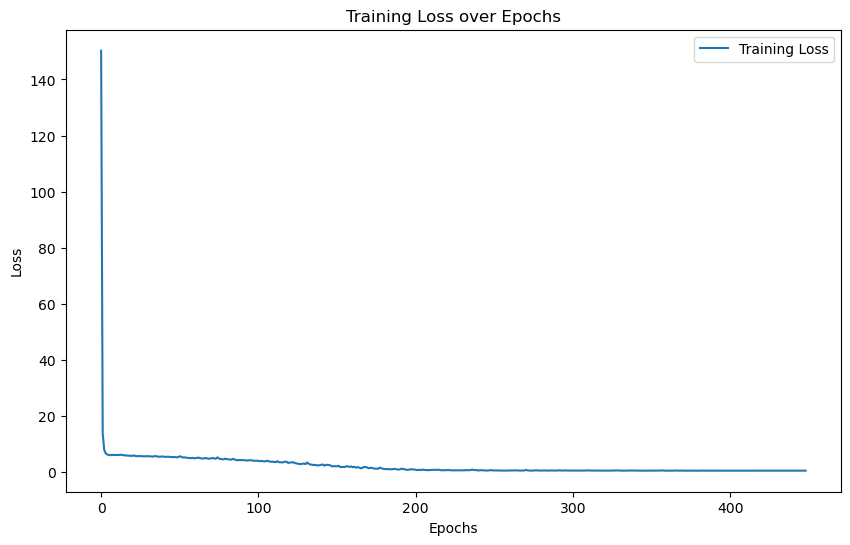

In [6]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 40),  # Input layer with 3 inputs (x, y, z)
            nn.ReLU(),         # Activation function
            nn.Linear(40, 100),
            nn.ReLU(),         # Activation function
            nn.Linear(100, 100),
            nn.ReLU(),         # Activation function
            nn.Linear(100, 40),
            nn.ReLU(),         # Activation function
            nn.Linear(40, 1)   # Output layer with 1 output (n)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the model
model = MLP()

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Set matplotlib to interactive mode
plt.ion()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
train_losses = []

# Training loop
num_epochs = 10000  # Adjust this as needed
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Update the plot
    ax.clear()
    ax.plot(train_losses, label='Training Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss over Epochs')
    ax.legend()
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Optional: print epoch number and loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Turn off interactive mode
plt.ioff()
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Average Test Loss: {average_loss:.4f}')


Average Test Loss: 0.8227


In [ ]:
pickle.dump(model, open("model_test.pickle", "wb"))